# 03 — Tweak: Use a Surrogate Model

Here we **swap in a learned surrogate** that predicts logP from Morgan fingerprints.
You can (A) train it quickly, or (B) load a provided `models/surrogate_logp.pkl` if your instructor supplied one.

> The goal is to compare outcomes vs. the RDKit logP baseline.

In [51]:
import os, random, joblib, numpy as np, pandas as pd
from tqdm import trange
import selfies as sf

from rdkit import Chem, DataStructs
from rdkit.Chem import Crippen, AllChem

DATA_DIR = os.path.join("..","data")
OUT_DIR = os.path.join("..","outputs")
MODEL_DIR = os.path.join("..","models")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

SEED = 23
random.seed(SEED); np.random.seed(SEED)

In [52]:
# Shared utilities
def smiles_to_mol(s):
    try:
        m = Chem.MolFromSmiles(s)
        if m is None: return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def morgan_fp(mol, radius=2, nbits=1024):
    from rdkit.Chem import rdFingerprintGenerator
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nbits)
    fp = gen.GetFingerprint(mol)
    return fp

def fp_to_numpy(fp):
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def to_selfies(smi):
    try:
        return sf.encoder(smi)
    except Exception:
        return None

def to_smiles(sf_s):
    try:
        return sf.decoder(sf_s)
    except Exception:
        return None

In [53]:
# (A) Train a quick surrogate model of logP
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

seed_smiles = pd.read_csv(os.path.join(DATA_DIR, "seed_smiles.csv"))["smiles"].tolist()

def random_valid_mutation(smi, tries=20):
    base = to_selfies(smi)
    if not base: return None
    for _ in range(tries):
        toks = list(sf.split_selfies(base))
        if not toks: toks = ["[C]"]
        op = random.choice(["insert","replace","delete"])
        if op == "delete" and len(toks) > 1:
            toks.pop(random.randrange(len(toks)))
        elif op == "insert":
            toks.insert(random.randrange(len(toks)+1), random.choice(list(sf.get_semantic_robust_alphabet())))
        else:
            idx = random.randrange(len(toks))
            toks[idx] = random.choice(list(sf.get_semantic_robust_alphabet()))
        candidate = "".join(toks)
        sm = to_smiles(candidate)
        if sm and smiles_to_mol(sm) is not None:
            return sm
    return None

def build_training_set(n=600):
    pool = []
    for s in seed_smiles:
        m = smiles_to_mol(s)
        if m: pool.append(s)
    while len(pool) < n:
        parent = random.choice(pool)
        child = random_valid_mutation(parent) or parent
        pool.append(child)
    # featurize
    X, y = [], []
    for smi in pool:
        m = smiles_to_mol(smi)
        if not m: continue
        fp = morgan_fp(m, nbits=1024)
        if fp is None: continue
        arr = np.zeros((1024,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        X.append(arr)
        y.append(Crippen.MolLogP(m))
    return np.array(X), np.array(y)

model_path = os.path.join(MODEL_DIR, "surrogate_logp.pkl")
X, y = build_training_set(n=800)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
print("Surrogate R^2 (holdout):", r2_score(yte, rf.predict(Xte)))
joblib.dump(rf, model_path)

[18:08:22] WARNING: not removing hydrogen atom without neighbors
[18:08:22] WARNING: not removing hydrogen atom without neighbors
[18:08:22] WARNING: not removing hydrogen atom without neighbors
[18:08:22] WARNING: not removing hydrogen atom without neighbors
[18:08:22] WARNING: not removing hydrogen atom without neighbors
[18:08:22] WARNING: not removing hydrogen atom without neighbors


Surrogate R^2 (holdout): 0.8496503727777034


['../models/surrogate_logp.pkl']

### Question
What is the surrogate model achieving?

Is it predictive?

Why might you use one yourself?

In [54]:
# (B) Load the surrogate
surrogate = joblib.load(model_path)

def predict_logp_surrogate(mol):
    fp = morgan_fp(mol, nbits=1024)
    if fp is None: return None
    arr = np.zeros((1024,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return float(surrogate.predict(arr.reshape(1,-1))[0])

In [55]:
# Generator with surrogate score
alpha = 0.02
beam_width = 10
neighbors_per_parent = 15
steps = 100

# seeds
seeds_df = pd.read_csv(os.path.join(DATA_DIR, "seed_smiles.csv"))
beam = []
for s in seeds_df["smiles"].tolist()[:beam_width]:
    sf_s = to_selfies(s)
    if sf_s: beam.append(sf_s)
if not beam: beam = ["[C][C][O]"]

seen, records = set(), []
best = {"score": -1e9, "smiles": None, "pred": None}

for t in trange(steps, desc="search (surrogate)"):
    proposals = []
    for parent in beam:
        for _ in range(neighbors_per_parent):
            child = parent
            # simple mutation
            toks = list(sf.split_selfies(child))
            if not toks: toks = ["[C]"]
            op = random.choice(["insert","replace","delete"])
            alphabet = list(sf.get_semantic_robust_alphabet())
            if op == "delete" and len(toks) > 1:
                toks.pop(random.randrange(len(toks)))
            elif op == "insert":
                toks.insert(random.randrange(len(toks)+1), random.choice(alphabet))
            else:
                idx = random.randrange(len(toks))
                toks[idx] = random.choice(alphabet)
            child = "".join(toks)

            smi = to_smiles(child)
            if not smi or smi in seen:
                continue
            mol = smiles_to_mol(smi)
            if mol is None: 
                continue
            pred = predict_logp_surrogate(mol)
            if pred is None: 
                continue
            # penalize size to avoid trivial chain growth
            score = pred - alpha*mol.GetNumHeavyAtoms()
            proposals.append((score, smi, child, {"pred_logP": pred, "heavy_atoms": mol.GetNumHeavyAtoms()}))
            seen.add(smi)
    if not proposals:
        continue
    proposals.sort(key=lambda x: x[0], reverse=True)
    beam = [p[2] for p in proposals[:beam_width]]
    top = proposals[0]
    records.append({"step": t, "smiles": top[1], "score": top[0], **top[3]})
    if top[0] > best["score"]:
        best = {"score": top[0], "smiles": top[1], "pred": top[3]["pred_logP"]}

import pandas as pd, os
df = pd.DataFrame(records)
df.to_csv(os.path.join(OUT_DIR, "tweaked_trace.csv"), index=False)

# Save top-50 by surrogate score
unique = {}
for r in sorted(records, key=lambda x: x["score"], reverse=True):
    smi = r["smiles"]
    if smi not in unique:
        unique[smi] = r
top_df = pd.DataFrame(list(unique.values())).sort_values("score", ascending=False).head(50)
top_df.to_csv(os.path.join(OUT_DIR, "tweaked_top50.csv"), index=False)

best

[18:09:49] WARNING: not removing hydrogen atom without neighbors███████████████████████████████████████████████████████████████████████▎                                                                                                                  | 49/100 [01:23<01:34,  1.86s/it]
search (surrogate): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


{'score': 2.978298733333342,
 'smiles': 'CC(C)CC1=CC=C(C=C1)C(C)C(=[O+1])O',
 'pred': 3.278298733333342}

### Question
How is this optimisation function working?


Why is the output molecule so different to the last excercise?

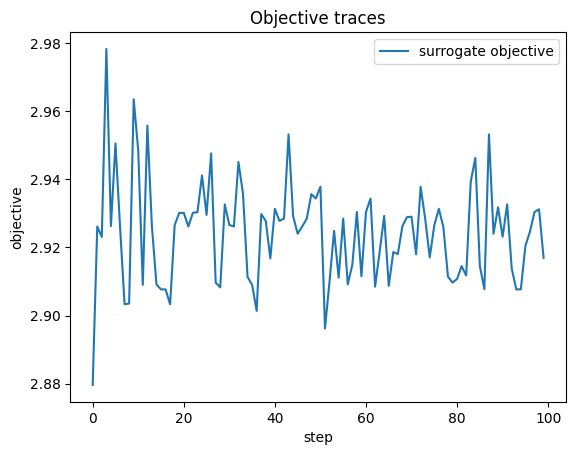

In [56]:
# Quick comparison plot (if baseline exists)
import matplotlib.pyplot as plt, pandas as pd, os
tweaked = pd.read_csv(os.path.join(OUT_DIR, "tweaked_trace.csv"))
plt.figure()
(tweaked["score"]).plot(kind="line", label="surrogate objective")
plt.legend(); plt.title("Objective traces"); plt.xlabel("step"); plt.ylabel("objective")
plt.show()


### Question 
What is going on here?

And why is it not doing the same as before?

In [57]:
# Quick comparison plot (if baseline exists)
import matplotlib.pyplot as plt, pandas as pd, os
base_path = os.path.join(OUT_DIR, "baseline_trace.csv")
if os.path.exists(base_path):
    base = pd.read_csv(base_path)
    tweaked = pd.read_csv(os.path.join(OUT_DIR, "tweaked_trace.csv"))
    plt.figure()
    (base["score"]).plot(kind="line", label="baseline objective")
    (tweaked["score"]).plot(kind="line", label="surrogate objective")
    plt.legend(); plt.title("Objective traces"); plt.xlabel("step"); plt.ylabel("objective")
    plt.show()
else:
    print("Run the baseline notebook first for a side-by-side trace.")

Run the baseline notebook first for a side-by-side trace.


### Assignment
Reflect on how you would improve the generator?

How would you improve the surrogate model?

What other models could you build?

How would you apply this to your problem?